# First Steps into using *pyforce*

*pyforce* is a Python package for data-driven reduced order modelling approaches built upon scientific computing libraries such as `numpy`, `scipy`, `scikit-learn` and `pyvista`. The main goal of *pyforce* consists in providing a rather simple and intuitive interface for researchers on this topic: even though the main focus of the authors is on nuclear reactors multi-physics scenarios (including fluid dynamics and neutronics mainly), the package is designed to be applicable to a wide range of problems in scientific computing and engineering.

This notebook wants to provide a first hands-on introduction to some basics classes and methods, which are needed to effectively use *pyforce* for your own applications. Before proceeding, this notebook supposes the reader has a basic knowledge of the ROM terminology.

In particular, in this tutorial you will learn how to:

- Generate custom snapshots on a `pyvista` grid and save them into `FunctionsList` objects (basic class using by *pyforce* to store data).
- Basic Plotting of `FunctionsList`.
- Write and read snapshots from disk using *pyforce* I/O functions.
- Calculate integral using `IntegralCalculator` class.

## Basics of the `FunctionsList` class
In this section, we are going to load an example mesh from `pyvista` and generate custom snapshots on it, exploring some basic functionalities of the `FunctionsList` class.

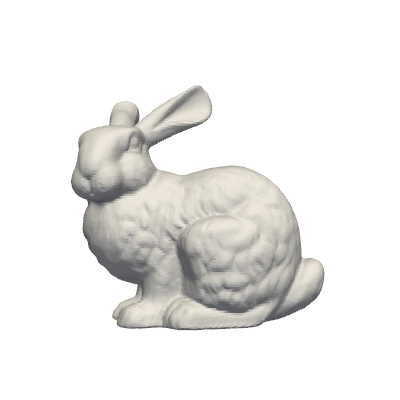

In [1]:
from pyvista import examples
import pyvista as pv
import numpy as np

grid = examples.download_bunny()

# Extract the points of the grid
nodes = grid.points

pl = pv.Plotter(window_size=[400, 400])
pl.add_mesh(grid, show_edges=False, color='white')
pl.view_xy()
pl.show(jupyter_backend='static') # jupyter_backend='html', 'trame'

Let $\mathbf{x}=(x,y,z)$ be the spatial coordinate of the mesh nodes, we are going to define a custom function, dependent on $\mathbf{x}$ and on a parameter $\mu$, as follows:
\begin{equation*}
f(x,y,z;\,\mu) = \sin\!\Big( \mu \sqrt{x^2 + y^2} + 5 \,\arctan\!\frac{y}{x} +\mu z\Big)
\end{equation*}

The `FunctionsList` class is used to store the snapshots, and it can be initialized by providing the number of nodes of the mesh. Snapshots can be appended to the `FunctionsList` object by using the `append` method.

In [2]:
from pyforce.tools.functions_list import FunctionsList

# Definining the function
def combo_field(coords, mu):
    x, y, z = coords.T
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return np.sin(mu * r + 5*theta + mu*z)

# Initialization of the class
snapshots = FunctionsList(nodes.shape[0])

mu_samples = np.linspace(100, 200, 100)
for mu in mu_samples:
    snapshots.append(combo_field(nodes, mu=mu))

The `FunctionsList` comes with a plotting method, which can be used to visualize the sequence of snapshots.

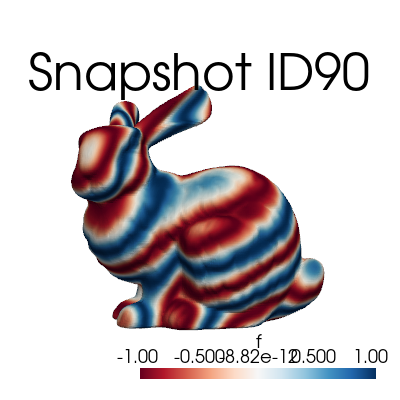

In [3]:
snapshots.plot_sequence(grid, 
                        sampling=5, view='xy', cmap='RdBu', resolution=[400,400], title='Snapshot ID', varname='f',  # optional
                        )

The class comes also with a method to plot a single snapshot, by providing its index in the list.

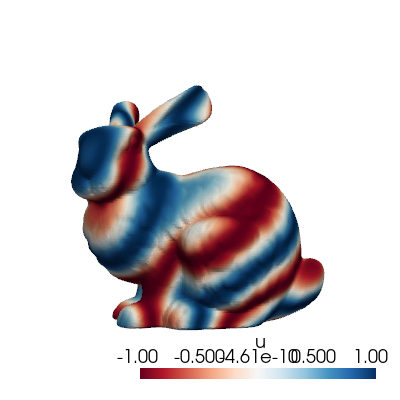

In [4]:
snapshots.plot(grid, idx_to_plot=10, 
                cmap='RdBu', resolution=[400,400] # optional
                )

Before delving into the I/O functionalities, let's mention some useful methods of the `FunctionsList` class:

- `return_matrix`: Returns the stored snapshots as a 2D NumPy array, whose shape is `(n_space, n_snapshots)` $\longleftrightarrow (\mathcal{N}_h, N_s)$.
- `build_from_matrix`: Builds the snapshot list from a 2D NumPy array, whose shape is `(n_space, n_snapshots)`.
- `lin_combine`: Linearly combines the stored snapshots using given coefficients (useful for reduced basis approximation). Consider $\boldsymbol{\alpha}\in N_s$, the elements $f_i$ of the `FunctionsList` are linearly combined as follows:
\begin{equation*}
F(\mathbf{x}) = \sum_{i=1}^{N_s} \alpha_i f_i(\mathbf{x})
\end{equation*}
- `min`, `max`, `mean`, `std`: Returns the minimum, maximum, mean and standard deviation of the stored snapshots, respectively.

## I/O methods within *pyforce*
In this section, we are going to explore the I/O functionalities of *pyforce*.

Starting from the `FunctionsList` object generate before, we can store them using the `store` method. The data can be store in `h5` or `npz` format (either compressed or not).

In [5]:
snapshots.store(var_name='f', 
                filename='example_snaps', 
                format = 'h5', 
                compression=True)

snapshots.store(var_name='f', 
                filename='example_snaps', 
                format = 'npz', 
                compression=True)

Once the data, these can be loaded with the `ImportFunctionsList` function.

In [6]:
from pyforce.tools.write_read import ImportFunctionsList

snaps_h5 = ImportFunctionsList('example_snaps', format='h5')
snaps_npz = ImportFunctionsList('example_snaps', format='npz')

# Check if the import was successful
np.max(np.abs(snaps_h5.return_matrix() - snapshots.return_matrix())), np.max(np.abs(snaps_npz.return_matrix() - snapshots.return_matrix()))

# Clean up
! rm example_snaps.*

The *pyforce* package provides also a class to import snapshots from an OpenFOAM simulation through the `ReadFromOF` class: this class will be explained in details in future tutorials since it will be extended used.

## Integral Calculations
Integrals can be calculated through the `IntegralCalculator` class: in this section, we are going to explore its functionalities.

At first, let us load a grid from the [cavity problem](https://www.openfoam.com/documentation/tutorial-guide/2-incompressible-flow/2.1-lid-driven-cavity-flow).


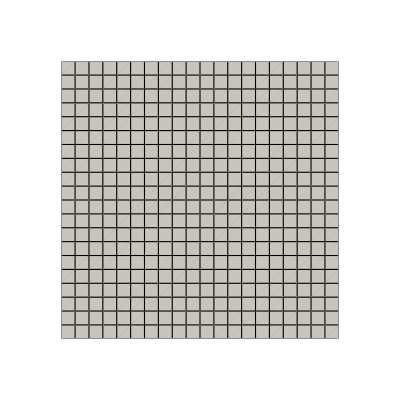

In [7]:
from pyvista import examples
grid  = examples.download_cavity()['internalMesh']
grid.clear_data()

pl = pv.Plotter(window_size=[400, 400])
pl.add_mesh(grid, show_edges=True, color='white')
pl.view_xy()
pl.show(jupyter_backend='static') # jupyter_backend='html', 'trame'

Let us consider two functions:
\begin{equation*}
\begin{split}
u(x,y) &= x^2+y^2 \\
v(x,y) &= x^3 + y
\end{split}
\end{equation*}
and evaluate them on the cavity grid.

A plot using `matplotlib` is also provided.

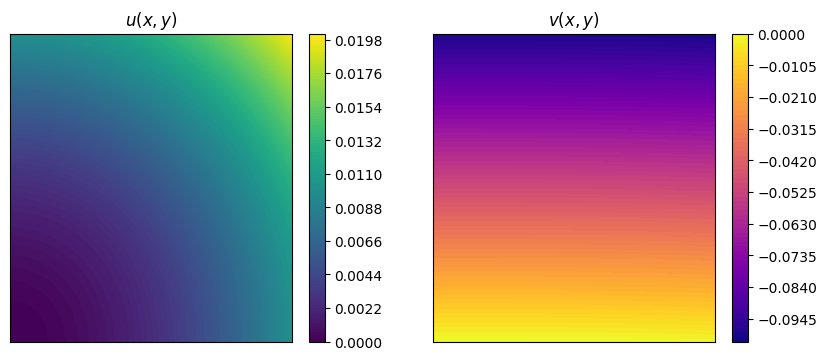

In [8]:
nodes = grid.points

u = nodes[:, 0]**2 + nodes[:, 1]**2
v = -nodes[:, 0]**3 - nodes[:, 1]

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(10,4))

cont_u = axs[0].tricontourf(nodes[:,0], nodes[:,1], u, levels=100, cmap="viridis")
cbar_u = fig.colorbar(cont_u, ax=axs[0])
axs[0].set_title('$u(x,y)$')

cont_v = axs[1].tricontourf(nodes[:,0], nodes[:,1], v, levels=100, cmap="plasma")
cbar_v = fig.colorbar(cont_v, ax=axs[1])
axs[1].set_title('$v(x,y)$')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

The `IntegralCalculator` class can be initialized by providing the grid. There are different integrals that can be computed, such as ($\Omega$ is the spatial domain, which is $[0,1/10]\times[0,1/10]\times[0,1/100]$ in this case):

\begin{equation*}
\begin{split}
\text{Integral:} \quad & \int_\Omega u(x,y) \, d\Omega =  \Delta z \cdot \frac{2}{10} \cdot \frac{1}{3000} = \Delta z \cdot \frac{1}{15000} \\
\text{Average:} \quad & \frac{1}{|\Omega|} \int_\Omega u(x,y) \, d\Omega = ... = \frac{1}{\Delta x\cdot \Delta y\cdot \Delta z}\Delta z \cdot \frac{1}{15000} = \frac{1}{150}\\
L^1\text{-norm:} \quad & \|v\|_{L^1(\Omega)}=\int_\Omega |v(x,y)| \, d\Omega\\
L^2\text{ inner product:} \quad & (u,v)_{L^2(\Omega)}=\int_\Omega u(x,y)\cdot v(x,y) \, d\Omega\\
L^2\text{-norm:} \quad & \|u\|_{L^2(\Omega)}=\sqrt{\int_\Omega u(x,y)^2 \, d\Omega}
\end{split}
\end{equation*}

In [9]:
from pyforce.tools.backends import IntegralCalculator

calc = IntegralCalculator(grid, gdim = 3)

integrals = {
    'integral': calc.integral(u),
    'average ': calc.average(u),
    'L1_norm ': calc.L1_norm(v),
    'L2_inner': calc.L2_inner_product(u, v),
    'L2_norm ': calc.L2_norm(u)
}

for key, value in integrals.items():
    print(f"{key}: {value:.8e}")

integral: 6.67500029e-07
average : 6.67500024e-03
L1_norm : 5.02506261e-06
L2_inner: -4.19379194e-08
L2_norm : 7.89163352e-05
